# Classifying Knee Images

## 1 Imports

In [1]:
# omit tensorflow import futurewarnings
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
print('TensorFlow version: ', tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout

from tensorflow import keras
from tensorflow.keras import Model, preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

TensorFlow version:  2.5.0


## 2 Load the data

## 2.1 Different setup criteria
Code will differ based on whether we are running on Google Colab or on a local machine

### 2.1.1 On local machine

In [ ]:
# directory = "../data/"

### 2.1.2 On Google Colab

In [2]:
!wget --no-check-certificate \
    "https://github.com/fontainelam/KneeOsteoarthritis/archive/refs/heads/main.zip" \
    -O "/tmp/knee-data.zip"

zip_ref = zipfile.ZipFile('/tmp/knee-data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2021-06-14 04:00:31--  https://github.com/fontainelam/KneeOsteoarthritis/archive/refs/heads/main.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/fontainelam/KneeOsteoarthritis/zip/refs/heads/main [following]
--2021-06-14 04:00:31--  https://codeload.github.com/fontainelam/KneeOsteoarthritis/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/knee-data.zip’

/tmp/knee-data.zip      [             <=>    ] 172.63M  41.4MB/s    in 4.7s    

2021-06-14 04:00:36 (36.6 MB/s) - ‘/tmp/knee-data.zip’ saved [181014851]



In [3]:
!ls /tmp/KneeOsteoarthritis-main/data/

test  train  val


In [4]:
os.listdir("/tmp/KneeOsteoarthritis-main/data/")

['train', 'val', 'test']

In [6]:
directory = "/tmp/KneeOsteoarthritis-main/data/"

## 2.2 Load files

In [7]:
train_directory = directory + "train"
test_directory = directory + "test"
val_directory = directory + "val"

In [8]:
batch_size = 32
img_height = 224
img_width = 224

def fetch_image_data_from_directory( dir_path, shuffle ):
    return tf.keras.preprocessing.image_dataset_from_directory(
    dir_path,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    smart_resize=False,
)

In [9]:
train_dataset = fetch_image_data_from_directory(train_directory, True)

Found 5778 files belonging to 5 classes.


In [10]:
val_dataset = fetch_image_data_from_directory(val_directory, True)

Found 826 files belonging to 5 classes.


In [11]:
test_dataset = fetch_image_data_from_directory(test_directory, False) # no need to shuffle the test dataset

Found 1656 files belonging to 5 classes.


In [12]:
def fetch_files_from_directory( dir_path ):
  file_dict = {}
  for grade in os.listdir( dir_path ):
    file_dict[grade] = os.listdir(dir_path + '/' + grade)
  return file_dict

In [13]:
train_files = fetch_files_from_directory(train_directory)
val_files = fetch_files_from_directory(val_directory)
test_files = fetch_files_from_directory(test_directory)

## 3 Explore the data

In [14]:
print('Training data: ', train_dataset.element_spec)
print('Validation data: ', val_dataset.element_spec)
print('Testing data: ', test_dataset.element_spec)

Training data:  (TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Validation data:  (TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Testing data:  (TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [15]:
sns.set_style("dark")

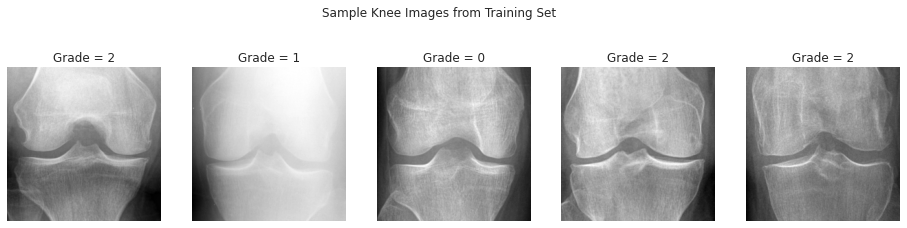

In [16]:
plt.figure(figsize=(16, 4))
for images, labels in train_dataset.take(1):
    for i in range(5):
        ax = plt.subplot(1,5,i+1)
        ax.axis('off')
        plt.imshow(images[i].numpy().squeeze().astype('uint8'),cmap='gray')
        ax.set_title('Grade = ' + str(labels[i].numpy()))
_ = plt.suptitle('Sample Knee Images from Training Set')

In [17]:
def plot_distribution(set_of_files, title):
    f, ax = plt.subplots(figsize=(16,6))
    keys = sorted(list(set_of_files.keys()))
    vals = [len(set_of_files[k]) for k in keys]
    sns.barplot(x=keys, y=vals, palette="Blues_d")
    plt.xlabel('Knee Severity Grade')
    plt.title(title)

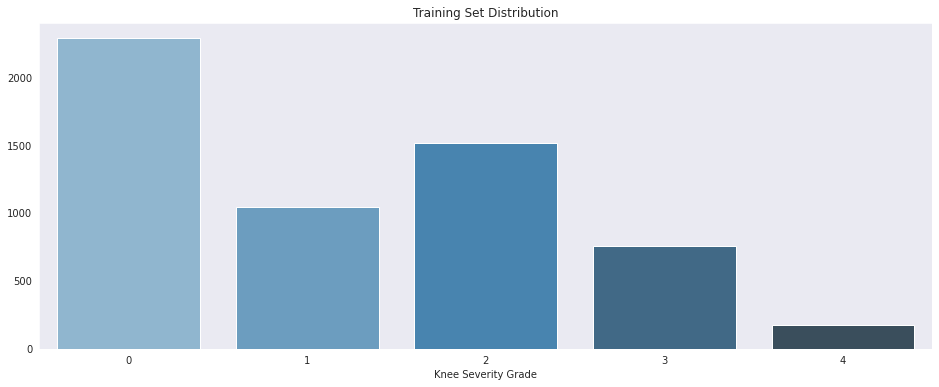

In [18]:
plot_distribution(train_files, 'Training Set Distribution')

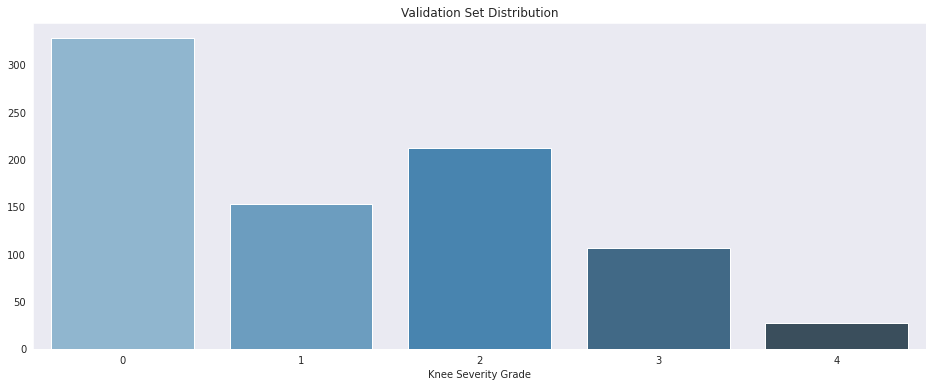

In [19]:
plot_distribution(val_files, 'Validation Set Distribution')

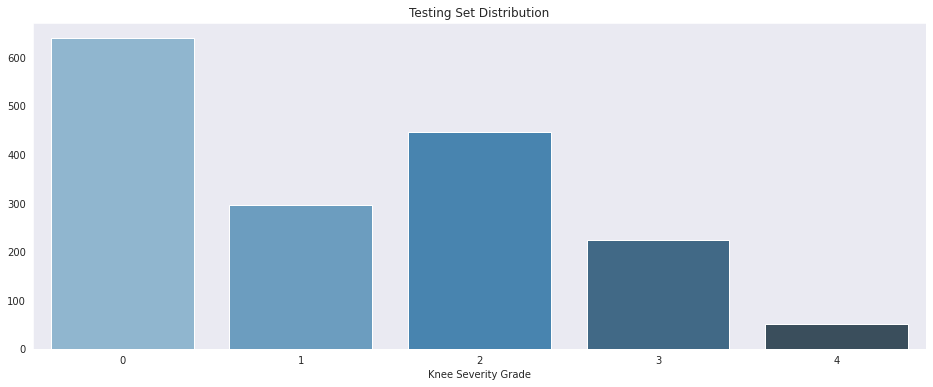

In [20]:
plot_distribution(test_files, 'Testing Set Distribution')

## 4 Model

### 4.1 Building the model

In [38]:
num_classes = 5

model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(img_height, img_width, 1), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [39]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [40]:
model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 110, 110, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 96800)            

Since we can see from our earlier distribution plots that we have imbalanced data, we will use __class weights__ to aid our model.

In [35]:
train_labels_from_files = []
for k, v in train_files.items():
    num_files = len(v)
    print('grade', k, 'contains', num_files, 'images')
    train_labels_from_files.extend([int(k)]* num_files)
print('total number of images:', len(train_labels_from_files))

grade 0 contains 2286 images
grade 3 contains 757 images
grade 2 contains 1516 images
grade 1 contains 1046 images
grade 4 contains 173 images
total number of images: 5778


In [36]:
class_weights_dict = dict(enumerate(class_weight.compute_class_weight('balanced', np.asarray(range(5)), train_labels_from_files)))
print(class_weights_dict)

{0: 0.5055118110236221, 1: 1.1047801147227534, 2: 0.7622691292875989, 3: 1.5265521796565389, 4: 6.679768786127168}


In [42]:
num_epochs = 12
history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs, class_weight=class_weights_dict)

Epoch 1/12
181/181 [==============================] - 327s 2s/step - loss: 34.7794 - accuracy: 0.2027 - val_loss: 2.1287 - val_accuracy: 0.1489
Epoch 2/12
181/181 [==============================] - 328s 2s/step - loss: 3.2930 - accuracy: 0.2214 - val_loss: 1.9812 - val_accuracy: 0.1199
Epoch 3/12
181/181 [==============================] - 328s 2s/step - loss: 2.3769 - accuracy: 0.2195 - val_loss: 1.6243 - val_accuracy: 0.1186
Epoch 4/12
181/181 [==============================] - 327s 2s/step - loss: 1.9359 - accuracy: 0.2150 - val_loss: 1.6103 - val_accuracy: 0.1780
Epoch 5/12
181/181 [==============================] - 326s 2s/step - loss: 1.7417 - accuracy: 0.2214 - val_loss: 1.6107 - val_accuracy: 0.1780
Epoch 6/12
181/181 [==============================] - 325s 2s/step - loss: 1.6745 - accuracy: 0.2214 - val_loss: 1.6112 - val_accuracy: 0.1792
Epoch 7/12
181/181 [==============================] - 325s 2s/step - loss: 1.6373 - accuracy: 0.1921 - val_loss: 1.6115 - val_accuracy: 0.175

### 4.2 Training and Validation Accuracy and Loss

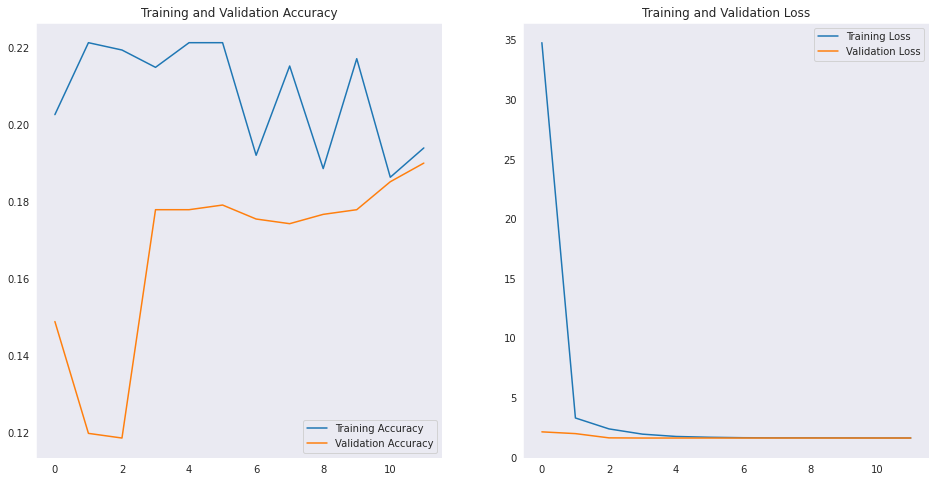

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 4.3 Predictions on test set

In [44]:
all_predictions = []
y_pred = []
y_test = []
test_images = None
first_batch = True

for image_batch, label_batch in test_dataset:
    predictions = model.predict(image_batch)
    all_predictions.append(predictions)
    y_pred.append(predictions.argmax(axis=1))
    if first_batch:
        test_images = image_batch.numpy()
        first_batch = False
    y_test.append(label_batch)

In [45]:
predicted_labels = tf.concat([item for item in y_pred], axis=0)
true_labels = tf.concat([item for item in y_test], axis=0)
predictions = tf.concat([item for item in all_predictions],axis=0)

#### 4.3.1 Model accuracy

In [46]:
accuracy_score = 100 * np.sum(predicted_labels.numpy() == true_labels.numpy())/len(predictions)
print('Accuracy of model: {:.2f} percent'.format(accuracy_score))

Accuracy of model: 18.06 percent


#### 4.3.2 Confusion matrix

In [47]:
cm = confusion_matrix(true_labels, predicted_labels)
cm

array([[ 36, 564,   7,   2,  30],
       [ 17, 258,   4,   0,  17],
       [ 11, 405,   5,   4,  22],
       [ 12, 198,   3,   0,  10],
       [  4,  45,   2,   0,   0]])

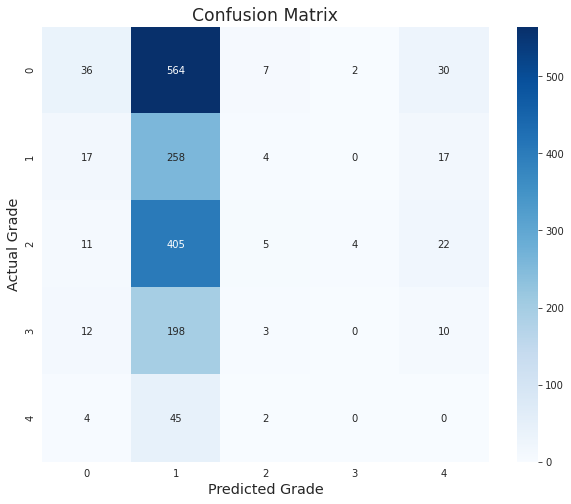

In [49]:
plt.figure(figsize=(10, 8))
_ = sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')
plt.xlabel('Predicted Grade', size='x-large')
plt.ylabel('Actual Grade', size='x-large')
_ = plt.title('Confusion Matrix',size='xx-large')

#### 4.3.3 Classification Report

In [50]:
clr = classification_report(true_labels, predicted_labels, zero_division=0)
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.45      0.06      0.10       639
           1       0.18      0.87      0.29       296
           2       0.24      0.01      0.02       447
           3       0.00      0.00      0.00       223
           4       0.00      0.00      0.00        51

    accuracy                           0.18      1656
   macro avg       0.17      0.19      0.08      1656
weighted avg       0.27      0.18      0.10      1656



#### 4.3.4 Sample images from test set

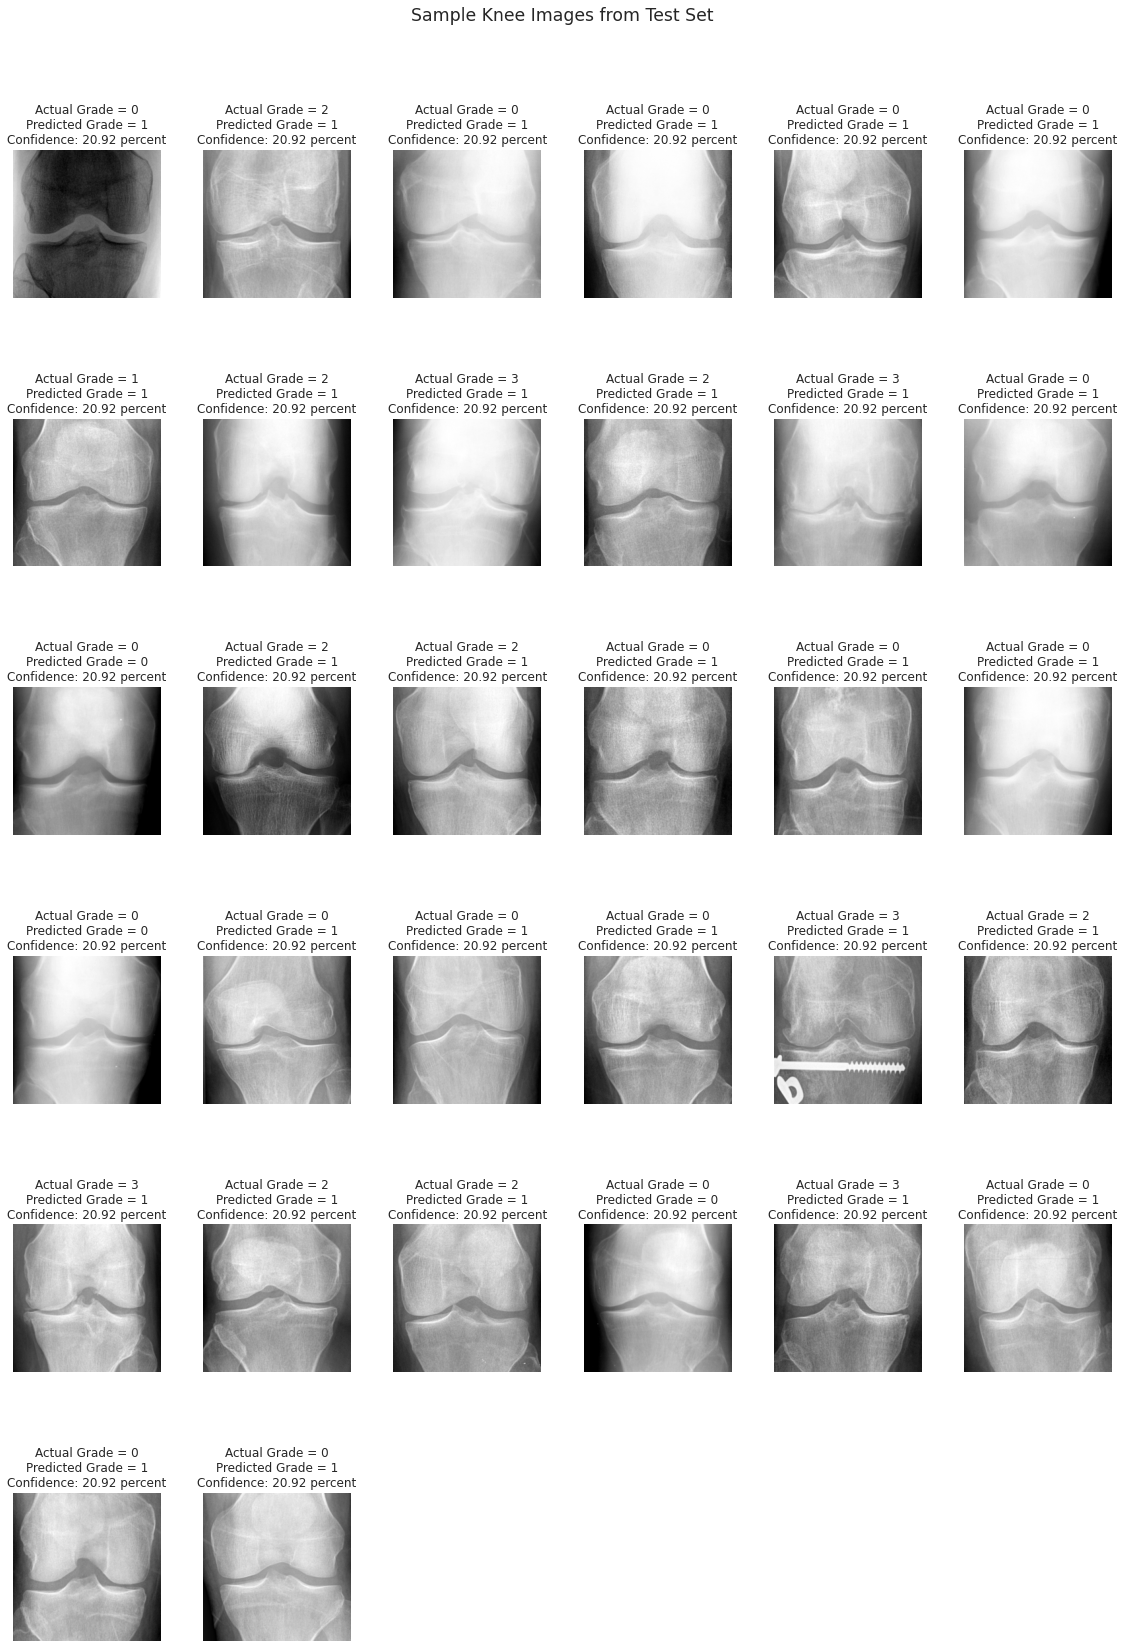

In [60]:
plt.figure(figsize=(16, 25))

for img_num in range(len(test_images)):
    ax = plt.subplot(6,6,img_num+1)
    ax.axis('off')
    plt.imshow(test_images[img_num].squeeze().astype('uint8'), cmap='gray')
    actual_grade = true_labels[img_num].numpy()
    pred_grade = predicted_labels[img_num].numpy()
    score = 100*np.max(tf.nn.softmax(predictions))
    title = "Actual Grade = {}\nPredicted Grade = {}\nConfidence: {:.2f} percent".format(actual_grade, pred_grade, score)
    ax.set_title(title) 
_ = plt.suptitle('Sample Knee Images from Test Set', size='xx-large')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])